In [20]:
import pandas as pd
import numpy as np
import math

In [22]:
df = pd.read_csv('all-stocks-5yr.csv')
df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL


In [23]:
z = df.loc[df['Name'] == 'ZTS']
z.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1259 entries, 617781 to 619039
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    1259 non-null   object 
 1   open    1259 non-null   float64
 2   high    1259 non-null   float64
 3   low     1259 non-null   float64
 4   close   1259 non-null   float64
 5   volume  1259 non-null   int64  
 6   Name    1259 non-null   object 
dtypes: float64(4), int64(1), object(2)
memory usage: 78.7+ KB


In [24]:
treino = z.iloc[:, 4:5].values
treino

array([[33.05],
       [33.26],
       [33.74],
       ...,
       [73.83],
       [73.27],
       [73.86]])

In [25]:
from sklearn.preprocessing import MinMaxScaler

# Criando um objeto MinMaxScaler
sc = MinMaxScaler()

# Aplicando a transformação de escala nos dados de treino
sc1 = sc.fit_transform(treino)

In [8]:
x_treino = []  # Lista para armazenar as sequências de entrada
y_treino = []  # Lista para armazenar os valores de saída correspondentes
timestamp = 45  # Tamanho da janela de tempo deslizante
length = len(treino)  # Comprimento dos dados de treino

# Criando as sequências de entrada (x_treino) e os valores de saída (y_treino)
for i in range(timestamp, length):
    # Cria uma sequência de entrada com base na janela de tempo deslizante
    # A sequência contém os valores de sc1 a partir de i - timestamp até i (exclusivo)
    x_treino.append(sc1[i - timestamp:i, 0])
    
    # O valor de saída correspondente é o valor de sc1 no índice i
    y_treino.append(sc1[i, 0])

# Converte as listas em arrays numpy
x_treino = np.array(x_treino)
y_treino = np.array(y_treino)

In [26]:
x_treino = np.reshape(x_treino, (x_treino.shape[0], x_treino.shape[1], 1))
x_treino.shape

(1214, 45, 1)

In [21]:
from keras.models import Sequential
from keras.layers import GRU, Dropout, Dense

# Inicializa um modelo sequencial
model = Sequential()

# Adiciona uma camada LSTM com 120 unidades, retornando sequências completas.
# A entrada é uma janela de tempo de forma (tamanho_da_janela_de_tempo, 1)
model.add(GRU(units=120, return_sequences=True, input_shape=(x_treino.shape[1], 1)))
model.add(Dropout(0.2))  # Adiciona uma camada de dropout para regularização

# Adiciona mais uma camada LSTM com 120 unidades e dropout
model.add(GRU(units=120, return_sequences=True))
model.add(Dropout(0.2))

# Adiciona mais uma camada LSTM com 120 unidades e dropout
model.add(GRU(units=120, return_sequences=True))
model.add(Dropout(0.2))

# Adiciona uma camada LSTM final com 120 unidades, retornando apenas o último valor
model.add(GRU(units=120, return_sequences=False))
model.add(Dropout(0.2))

# Adiciona uma camada densa com 1 unidade de saída para finalizar a previsão
model.add(Dense(units=1))

# Compila o modelo com otimizador 'adam' e função de perda 'mean_squared_error'
model.compile(optimizer='adam', loss='mean_squared_error')

# Imprime um resumo da arquitetura do modelo
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_4 (GRU)                 (None, 45, 120)           44280     
                                                                 
 dropout_12 (Dropout)        (None, 45, 120)           0         
                                                                 
 gru_5 (GRU)                 (None, 45, 120)           87120     
                                                                 
 dropout_13 (Dropout)        (None, 45, 120)           0         
                                                                 
 gru_6 (GRU)                 (None, 45, 120)           87120     
                                                                 
 dropout_14 (Dropout)        (None, 45, 120)           0         
                                                                 
 gru_7 (GRU)                 (None, 120)              

In [27]:
# padrão epochs = 200
#coloquei 1 para ganhar tempo
model.fit(x_treino, y_treino, epochs = 1, batch_size = 32)

38/38 [==============================] - 71s 1s/step - loss: 0.0145


In [30]:
# Selecionando os dados específicos do DataFrame df onde a coluna 'Name' é igual a 'BA'
teste = df[df['Name'] == 'BA']

# Selecionando somente a coluna 'close' do DataFrame teste
teste = teste.loc[:, ['close']]

# Definindo o número de lags para usar como timestamp
timestamp = 45

# Criando a variável y_treino usando os valores de 'close' a partir do índice 'timestamp'
y_treino = teste['close'].iloc[timestamp:].values

In [31]:
clossing_price = teste.iloc[:,0:].values
clossing_price_scaled = sc.transform(clossing_price)

In [33]:
# Inicializando uma lista vazia para armazenar os dados de teste
x_teste = []

# Obtendo o comprimento dos dados de teste
length = len(teste)

# Iterando sobre os dados de teste
for i in range(timestamp, length):
    # Adicionando os dados escalados de fechamento à lista x_teste
    x_teste.append(clossing_price_scaled[i - timestamp:i, 0])

# Convertendo a lista para um array numpy
x_teste = np.array(x_teste)

# Redimensionando os dados de teste para o formato adequado para a entrada do modelo LSTM
x_teste = x_teste.reshape(x_teste.shape[0], x_teste.shape[1], 1)

In [34]:
# Realizando a previsão dos preços das ações usando o modelo treinado
y_predict = model.predict(x_teste)

# Invertendo a transformação para obter os valores originais dos preços
predict_price = sc.inverse_transform(y_predict)

38/38 [==============================] - 21s 417ms/step


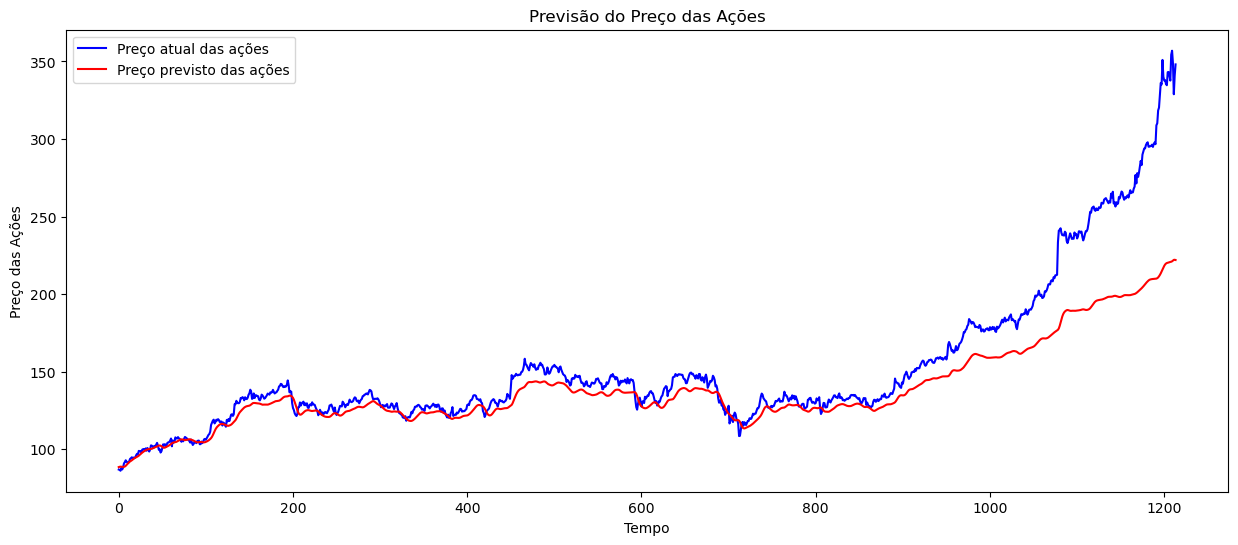

In [35]:
# Importando a biblioteca necessária para visualização
import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams
rcParams['figure.figsize'] = 15, 6

# Plot dos preços reais das ações (em azul) e preços previstos (em vermelho)
plt.plot(y_treino, color='b', label='Preço atual das ações')
plt.plot(predict_price, color='r', label='Preço previsto das ações')

# Adicionando título e rótulos dos eixos
plt.title('Previsão do Preço das Ações')
plt.xlabel('Tempo')
plt.ylabel('Preço das Ações')

# Adicionando legenda para as linhas
plt.legend()

# Exibindo o gráfico
plt.show()